# TCC em Ciência de Dados e Big Data

# PUC MINAS

------------------------------------------------------------

# TÍTULO:

# Predição de cancelamentos de voos dada as condições meteorológicas do momento por modelos de machine learning

------------------------------------------------------------

# 1. Definição do problema

## De vez em quando ocorrem acidentes devido às condições meteorológicas na face da terra. E por isso é importante estudar a segurança que esse fenômenos perturbam.

## O objetivo deste artigo é avaliar os voos cancelados no período de 2019 e as condições meteorológicas presentes no momento do cancelamento. O registro dessas condições são avaliados por um modelo de machine learning que prediz se determinado voo será cancelado ou não dadas as condições meteorológicas.

## O modelo tem por principal conduta estudar em que condições houveram os cancelamentos através da análise dos dados dos voos históricos registrados e disponibilizados pela ANAC no site:
https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/historico-de-voos
## O Voo Regular Ativo – VRA é uma base de dados composta por informações de voos de empresas de transporte aéreo que apresenta os cancelamentos e horários em que os voos ocorreram.

## As condições meteorológicas foram selecionadas para ser o mais fiel possível do banco de dados que é analisado pelos própios pilotos, e para essas condições meteorológicas são utilizados os dados do METAR.
## Esses dados são captados próximos aos aeroportos e trazem informações como: Termperatura, velocidade do vento, visibilidade do céu, umidade relativa e vários outros fenômenos.

## Esse banco de dados foi retirado da Iowa State University que possui todas as condições meteorológicas de 2019, que é atualizado a cada hora, nos 10 principais aeroportos do Brasil.
## Segue o site de onde foi feita a requisição:
https://mesonet.agron.iastate.edu/request/download.phtml

------------------------------------------------------------

# Início do código

## Importação das bibliotecas necessárias para o projeto

In [1]:
import datetime
import string
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import imblearn


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier      
from sklearn.linear_model import LogisticRegression  
from imblearn.under_sampling import NearMiss
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn import model_selection                     
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')
import io, os, sys, types, time, math, random, subprocess, tempfile

------------------------------------------------------------

# 2. Coleta de dados

### A primeira situação que deve ser analisada é o banco de dados e qual é o objetivo da utilização de cada coluna. Ao final da análise o dataframe df00 não será integrado ao banco de dados final, ele apenas servirá de guia para a seleção das colunas(features).

In [2]:
df00 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/percentuais-de-atrasos-e-cancelamentos-2/2019/vra_012019.csv', 
                       delimiter= ';',encoding='iso-8859-1', low_memory=False)
df00

,ICAO Empresa Aérea,Número Voo,Código DI,Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situação Voo,Código Justificativa
0,AAF,35,0,I,LFPO,SBKP,25/01/2019 06:15,25/01/2019 06:15,25/01/2019 18:15,25/01/2019 18:15,REALIZADO,NaN
1,AAF,35,0,I,LFPO,SBKP,27/01/2019 06:15,27/01/2019 06:15,27/01/2019 18:15,27/01/2019 18:15,REALIZADO,NaN
2,AAF,35,0,I,LFPO,SBKP,29/01/2019 06:15,29/01/2019 06:15,29/01/2019 18:15,29/01/2019 18:15,REALIZADO,NaN
3,AAF,36,0,I,SBKP,LFPO,25/01/2019 20:15,25/01/2019 20:15,26/01/2019 07:45,26/01/2019 07:45,REALIZADO,NaN
4,AAF,36,0,I,SBKP,LFPO,27/01/2019 20:15,27/01/2019 20:15,28/01/2019 07:45,28/01/2019 07:45,REALIZADO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
91812,UPS,417,0,G,SBKP,SKBO,29/01/2019 01:50,29/01/2019 01:50,29/01/2019 07:22,29/01/2019 07:22,REALIZADO,NaN
91813,UPS,417,0,G,SKBO,KMIA,08/01/2019 10:11,08/01/2019 08:08,08/01/2019 13:44,08/01/2019 12:02,REALIZADO,HI
91814,UPS,417,0,G,SKBO,KMIA,15/01/2019 10:11,15/01/2019 08:21,15/01/2019 13:44,15/01/2019 11:52,REALIZADO,HI
91815,UPS,417,0,G,SKBO,KMIA,22/01/2019 10:11,22/01/2019 10:11,22/01/2019 13:44,22/01/2019 13:44,REALIZADO,NaN


In [3]:
df00['Código Tipo Linha'].value_counts()

N    75543
I    14320
G     1436
C      451
L       67
Name: Código Tipo Linha, dtype: int64

## Percebe-se que o banco de dados disponibilizado pela ANAC possui algumas variáveis que são irrelevantes para análise. Dito Isso, serão removidas as colunas: 'Número voo', 'Código DI', 'Código Tipo Linha'.

In [4]:
df00

,ICAO Empresa Aérea,Número Voo,Código DI,Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situação Voo,Código Justificativa
0,AAF,35,0,I,LFPO,SBKP,25/01/2019 06:15,25/01/2019 06:15,25/01/2019 18:15,25/01/2019 18:15,REALIZADO,NaN
1,AAF,35,0,I,LFPO,SBKP,27/01/2019 06:15,27/01/2019 06:15,27/01/2019 18:15,27/01/2019 18:15,REALIZADO,NaN
2,AAF,35,0,I,LFPO,SBKP,29/01/2019 06:15,29/01/2019 06:15,29/01/2019 18:15,29/01/2019 18:15,REALIZADO,NaN
3,AAF,36,0,I,SBKP,LFPO,25/01/2019 20:15,25/01/2019 20:15,26/01/2019 07:45,26/01/2019 07:45,REALIZADO,NaN
4,AAF,36,0,I,SBKP,LFPO,27/01/2019 20:15,27/01/2019 20:15,28/01/2019 07:45,28/01/2019 07:45,REALIZADO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
91812,UPS,417,0,G,SBKP,SKBO,29/01/2019 01:50,29/01/2019 01:50,29/01/2019 07:22,29/01/2019 07:22,REALIZADO,NaN
91813,UPS,417,0,G,SKBO,KMIA,08/01/2019 10:11,08/01/2019 08:08,08/01/2019 13:44,08/01/2019 12:02,REALIZADO,HI
91814,UPS,417,0,G,SKBO,KMIA,15/01/2019 10:11,15/01/2019 08:21,15/01/2019 13:44,15/01/2019 11:52,REALIZADO,HI
91815,UPS,417,0,G,SKBO,KMIA,22/01/2019 10:11,22/01/2019 10:11,22/01/2019 13:44,22/01/2019 13:44,REALIZADO,NaN


In [5]:
df00.drop(df00.columns[1:4], axis=1, inplace=True)

In [6]:
df00 

,ICAO Empresa Aérea,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situação Voo,Código Justificativa
0,AAF,LFPO,SBKP,25/01/2019 06:15,25/01/2019 06:15,25/01/2019 18:15,25/01/2019 18:15,REALIZADO,NaN
1,AAF,LFPO,SBKP,27/01/2019 06:15,27/01/2019 06:15,27/01/2019 18:15,27/01/2019 18:15,REALIZADO,NaN
2,AAF,LFPO,SBKP,29/01/2019 06:15,29/01/2019 06:15,29/01/2019 18:15,29/01/2019 18:15,REALIZADO,NaN
3,AAF,SBKP,LFPO,25/01/2019 20:15,25/01/2019 20:15,26/01/2019 07:45,26/01/2019 07:45,REALIZADO,NaN
4,AAF,SBKP,LFPO,27/01/2019 20:15,27/01/2019 20:15,28/01/2019 07:45,28/01/2019 07:45,REALIZADO,NaN
...,...,...,...,...,...,...,...,...,...
91812,UPS,SBKP,SKBO,29/01/2019 01:50,29/01/2019 01:50,29/01/2019 07:22,29/01/2019 07:22,REALIZADO,NaN
91813,UPS,SKBO,KMIA,08/01/2019 10:11,08/01/2019 08:08,08/01/2019 13:44,08/01/2019 12:02,REALIZADO,HI
91814,UPS,SKBO,KMIA,15/01/2019 10:11,15/01/2019 08:21,15/01/2019 13:44,15/01/2019 11:52,REALIZADO,HI
91815,UPS,SKBO,KMIA,22/01/2019 10:11,22/01/2019 10:11,22/01/2019 13:44,22/01/2019 13:44,REALIZADO,NaN


## De acordo com a hipotése que foi levantada não há a necessidade de utilizarmos as colunas que seriam do destino final, pois será avaliado apenas as condições meteorológicas do aeroporto de origem. Portanto, serão deletadas as seguintes colunas: 'ICAO Aeródromo Destino', 'Partida Real', 'Chegada Prevista', 'Chegada Real'

In [7]:
df00.drop(df00.columns[4:7], axis=1, inplace=True)
df00

,ICAO Empresa Aérea,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Situação Voo,Código Justificativa
0,AAF,LFPO,SBKP,25/01/2019 06:15,REALIZADO,NaN
1,AAF,LFPO,SBKP,27/01/2019 06:15,REALIZADO,NaN
2,AAF,LFPO,SBKP,29/01/2019 06:15,REALIZADO,NaN
3,AAF,SBKP,LFPO,25/01/2019 20:15,REALIZADO,NaN
4,AAF,SBKP,LFPO,27/01/2019 20:15,REALIZADO,NaN
...,...,...,...,...,...,...
91812,UPS,SBKP,SKBO,29/01/2019 01:50,REALIZADO,NaN
91813,UPS,SKBO,KMIA,08/01/2019 10:11,REALIZADO,HI
91814,UPS,SKBO,KMIA,15/01/2019 10:11,REALIZADO,HI
91815,UPS,SKBO,KMIA,22/01/2019 10:11,REALIZADO,NaN


In [8]:
df00.drop(df00.columns[2:3], axis=1, inplace=True)
df00

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,AAF,LFPO,25/01/2019 06:15,REALIZADO,NaN
1,AAF,LFPO,27/01/2019 06:15,REALIZADO,NaN
2,AAF,LFPO,29/01/2019 06:15,REALIZADO,NaN
3,AAF,SBKP,25/01/2019 20:15,REALIZADO,NaN
4,AAF,SBKP,27/01/2019 20:15,REALIZADO,NaN
...,...,...,...,...,...
91812,UPS,SBKP,29/01/2019 01:50,REALIZADO,NaN
91813,UPS,SKBO,08/01/2019 10:11,REALIZADO,HI
91814,UPS,SKBO,15/01/2019 10:11,REALIZADO,HI
91815,UPS,SKBO,22/01/2019 10:11,REALIZADO,NaN


## A partir daqui será feito todas as request dos bancos de dados dos pela biblioteca Pandas, retornando os Dataframes em CSV separados por meses sendo o 'df01=janeiro' ate o 'df12=dezembro'. Esses bancos de dados são disponibilizados pelo governo federal, juntamente com a ANAC.

In [9]:
df01 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/percentuais-de-atrasos-e-cancelamentos-2/2019/vra_012019.csv', 
                       delimiter= ';',encoding='iso-8859-1', low_memory=False)

df01.drop(df01.columns[1:4], axis=1, inplace=True)
df01.drop(df01.columns[4:7], axis=1, inplace=True)
df01.drop(df01.columns[2:3], axis=1, inplace=True)

df01

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,AAF,LFPO,25/01/2019 06:15,REALIZADO,NaN
1,AAF,LFPO,27/01/2019 06:15,REALIZADO,NaN
2,AAF,LFPO,29/01/2019 06:15,REALIZADO,NaN
3,AAF,SBKP,25/01/2019 20:15,REALIZADO,NaN
4,AAF,SBKP,27/01/2019 20:15,REALIZADO,NaN
...,...,...,...,...,...
91812,UPS,SBKP,29/01/2019 01:50,REALIZADO,NaN
91813,UPS,SKBO,08/01/2019 10:11,REALIZADO,HI
91814,UPS,SKBO,15/01/2019 10:11,REALIZADO,HI
91815,UPS,SKBO,22/01/2019 10:11,REALIZADO,NaN


In [10]:
df02 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/percentuais-de-atrasos-e-cancelamentos-2/2019/vra_022019.csv', 
                       delimiter= ';',encoding='iso-8859-1', low_memory=False)

df02.drop(df02.columns[1:4], axis=1, inplace=True)
df02.drop(df02.columns[4:7], axis=1, inplace=True)
df02.drop(df02.columns[2:3], axis=1, inplace=True)

df02

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,AAF,LFPO,01/02/2019 06:15,REALIZADO,NaN
1,AAF,LFPO,03/02/2019 06:15,REALIZADO,NaN
2,AAF,LFPO,05/02/2019 06:15,REALIZADO,NaN
3,AAF,LFPO,08/02/2019 06:15,REALIZADO,NaN
4,AAF,LFPO,10/02/2019 06:15,REALIZADO,NaN
...,...,...,...,...,...
79521,UPS,SBKP,26/02/2019 00:50,REALIZADO,NaN
79522,UPS,SKBO,05/02/2019 10:11,REALIZADO,HI
79523,UPS,SKBO,12/02/2019 10:11,REALIZADO,HI
79524,UPS,SKBO,19/02/2019 09:11,REALIZADO,HI


In [11]:
df03 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/percentuais-de-atrasos-e-cancelamentos-2/2019/vra_032019.csv', 
                       delimiter= ';',encoding='iso-8859-1', low_memory=False)

df03.drop(df03.columns[1:4], axis=1, inplace=True)
df03.drop(df03.columns[4:7], axis=1, inplace=True)
df03.drop(df03.columns[2:3], axis=1, inplace=True)

df03.rename(columns={'ICAO Aeródromo Origem':'ICAO Aeródromo Origem','Data Partida Prevista':'Partida Prevista',
                     'Situação Voo':'Situação Voo','Código Justificativa':'Código Justificativa'}, inplace=True)
df03

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,AAL,KMIA,01/03/2019 01:15,REALIZADO,NaN
1,AAL,KMIA,02/03/2019 01:15,REALIZADO,NaN
2,AAL,KMIA,03/03/2019 01:15,REALIZADO,NaN
3,AAL,KMIA,04/03/2019 01:15,REALIZADO,NaN
4,AAL,KMIA,05/03/2019 01:15,REALIZADO,NaN
...,...,...,...,...,...
83057,UPS,SBKP,26/03/2019 00:20,REALIZADO,NaN
83058,UPS,SKBO,05/03/2019 09:11,REALIZADO,HI
83059,UPS,SKBO,12/03/2019 08:41,REALIZADO,HI
83060,UPS,SKBO,19/03/2019 08:41,REALIZADO,HI


In [12]:
df04 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/base-historica-1/vra/2019/VRA_AbriL_2019.csv', 
                       delimiter= ';' ,encoding='iso-8859-1', low_memory=False)

df04.dropna(subset=['Data Chegada Prevista'], how='all', inplace=True)
df04.drop(df04.columns[1:4], axis=1, inplace=True)
df04.drop(df04.columns[4:7], axis=1, inplace=True)
df04.drop(df04.columns[2:3], axis=1, inplace=True)

df04.rename(columns={'ï»¿ICAO Empresa AÃ©rea':'ICAO Empresa Aérea','CÃ³digo Tipo Linha':'Código Tipo Linha',
                     'ICAO AerÃ³dromo Origem':'ICAO Aeródromo Origem','Data Partida Prevista':'Partida Prevista',
                     'SituaÃ§Ã£o Voo':'Situação Voo','CÃ³digo Justificativa':'Código Justificativa'}, inplace=True)
df04

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,TPU,SPJC,31/03/2019 23:59,REALIZADO,AM
1,ONE,SBGR,01/04/2019 00:00,REALIZADO,NaN
2,ONE,SBGR,01/04/2019 00:00,REALIZADO,NaN
3,AAL,KMIA,01/04/2019 00:05,REALIZADO,TD
4,GLO,SBCT,01/04/2019 00:05,REALIZADO,AT
...,...,...,...,...,...
77437,AZU,SBFZ,01/05/2019 05:50,REALIZADO,NaN
77438,QTR,EBLG,01/05/2019 06:30,REALIZADO,NaN
77439,LAN,SBGR,01/05/2019 07:30,REALIZADO,TD
77440,LAN,LEMD,01/05/2019 10:05,REALIZADO,NaN


In [13]:
df05 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/base-historica-1/vra/2019/ANAC_VRA_05_2019.csv', 
                       delimiter= ';',encoding='iso-8859-1', low_memory=False)

df05.drop(df05.columns[1:4], axis=1, inplace=True)
df05.drop(df05.columns[4:7], axis=1, inplace=True)
df05.drop(df05.columns[2:3], axis=1, inplace=True)

df05.rename(columns={'ICAO Aeródromo Origem':'ICAO Aeródromo Origem','Data Partida Prevista':'Partida Prevista',
                     'Situação Voo':'Situação Voo','Código Justificativa':'Código Justificativa'}, inplace=True)
df05

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,AAF,LFPO,02/05/2019 05:15,REALIZADO,NaN
1,AAF,LFPO,03/05/2019 05:15,REALIZADO,NaN
2,AAF,LFPO,04/05/2019 05:15,REALIZADO,NaN
3,AAF,LFPO,05/05/2019 05:15,REALIZADO,NaN
4,AAF,LFPO,07/05/2019 05:15,REALIZADO,NaN
...,...,...,...,...,...
76696,UPS,SKBO,07/05/2019 07:10,REALIZADO,NaN
76697,UPS,SKBO,14/05/2019 07:10,REALIZADO,NaN
76698,UPS,SKBO,21/05/2019 07:10,REALIZADO,NaN
76699,UPS,SKBO,28/05/2019 07:10,REALIZADO,NaN


In [14]:
df06 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/base-historica-1/vra/2019/vra_062019.csv', 
                       delimiter= ';',encoding='iso-8859-1', low_memory=False)

df06.dropna(subset=['Data Chegada Prevista'], how='all', inplace=True)
df06.drop(df06.columns[1:4], axis=1, inplace=True)
df06.drop(df06.columns[4:7], axis=1, inplace=True)
df06.drop(df06.columns[2:3], axis=1, inplace=True)

df06.rename(columns={'ï»¿ICAO Empresa AÃ©rea':'ICAO Empresa Aérea','CÃ³digo Tipo Linha':'Código Tipo Linha',
                     'ICAO AerÃ³dromo Origem':'ICAO Aeródromo Origem','Data Partida Prevista':'Partida Prevista',
                     'SituaÃ§Ã£o Voo':'Situação Voo','CÃ³digo Justificativa':'Código Justificativa'}, inplace=True)
df06

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,AAF,LFPO,01/06/2019 05:15,REALIZADO,TD
1,AAF,LFPO,02/06/2019 05:15,REALIZADO,NaN
2,AAF,LFPO,04/06/2019 05:15,REALIZADO,NaN
3,AAF,LFPO,06/06/2019 05:15,REALIZADO,NaN
4,AAF,LFPO,07/06/2019 05:15,REALIZADO,NaN
...,...,...,...,...,...
74184,UPS,SBKP,25/06/2019 00:15,REALIZADO,NaN
74185,UPS,SKBO,04/06/2019 07:10,REALIZADO,NaN
74186,UPS,SKBO,11/06/2019 07:10,REALIZADO,NaN
74187,UPS,SKBO,18/06/2019 07:10,REALIZADO,NaN


In [15]:
df07 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/base-historica-1/vra/2019/vra_072019.csv', 
                       delimiter= '	',encoding='iso-8859-1', low_memory=False)

df07.dropna(subset=['Partida Prevista'], how='all', inplace=True)
df07.drop(df07.columns[1:4], axis=1, inplace=True)
df07.drop(df07.columns[4:7], axis=1, inplace=True)
df07.drop(df07.columns[2:3], axis=1, inplace=True)

df07

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,AAF,LFPO,02/07/2019 05:15,REALIZADO,AF
1,AAF,LFPO,02/07/2019 05:15,REALIZADO,MX
2,AAF,LFPO,02/07/2019 05:15,REALIZADO,MX
3,AAF,LFPO,04/07/2019 05:15,REALIZADO,NaN
4,AAF,LFPO,05/07/2019 05:15,REALIZADO,NaN
...,...,...,...,...,...
85667,UPS,SKBO,02/07/2019 07:10,REALIZADO,NaN
85668,UPS,SKBO,09/07/2019 07:10,REALIZADO,NaN
85669,UPS,SKBO,16/07/2019 07:10,REALIZADO,NaN
85670,UPS,SKBO,23/07/2019 07:10,REALIZADO,NaN


In [16]:
df08 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/base-historica-1/vra/2019/VRA_082019.csv', 
                       delimiter= ';',encoding='iso-8859-1', low_memory=False)

df08.drop(df08.columns[1:4], axis=1, inplace=True)
df08.drop(df08.columns[4:7], axis=1, inplace=True)
df08.drop(df08.columns[2:3], axis=1, inplace=True)

df08.rename(columns={'ICAO Empresa Aerea':'ICAO Empresa Aérea','Codigo Tipo Linha':'Código Tipo Linha',
                     'ICAO Aerodromo Origem':'ICAO Aeródromo Origem',
                     'Situacao Voo':'Situação Voo','Codigo Justificativa':'Código Justificativa'}, inplace=True)
df08

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,AEA,LEMD,24/08/2019 10:25,REALIZADO,RA
1,AEA,LEMD,24/08/2019 10:25,REALIZADO,RA
2,AEA,SBSV,24/08/2019 21:40,REALIZADO,RA
3,AEA,LEMD,27/08/2019 10:25,REALIZADO,RA
4,AEA,SBSV,27/08/2019 21:40,REALIZADO,AR
...,...,...,...,...,...
80584,AZU,SBTE,31/08/2019 16:55,CANCELADO,XT
80585,AZU,SBCY,31/08/2019 18:00,CANCELADO,XT
80586,AZU,SBVT,31/08/2019 18:20,CANCELADO,XT
80587,AZU,SBGL,31/08/2019 18:40,CANCELADO,XT


In [17]:
df09 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/base-historica-1/vra/2019/vra_092019.csv', 
                       delimiter= ';',encoding='iso-8859-1', low_memory=False)

df09.dropna(subset=['Partida Prevista'], how='all', inplace=True)
df09.drop(df09.columns[1:4], axis=1, inplace=True)
df09.drop(df09.columns[4:7], axis=1, inplace=True)
df09.drop(df09.columns[2:3], axis=1, inplace=True)
df09['Situação Voo'] = df09['Situação Voo'].replace({'NÃO REALIZADO':'CANCELADO'})

df09

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,UAL,KIAD,01/09/2019 23:00,REALIZADO,NaN
1,UAL,SBGR,01/09/2019 21:20,REALIZADO,NaN
2,UAL,KORD,01/09/2019 23:05,REALIZADO,NaN
3,UAL,SBGR,01/09/2019 22:20,REALIZADO,NaN
4,UAL,KEWR,01/09/2019 23:10,REALIZADO,MX
...,...,...,...,...,...
80532,AZU,SBKP,30/09/2019 23:45,REALIZADO,TD
80533,AZU,SBKP,30/09/2019 17:30,REALIZADO,NaN
80534,AZU,SBCT,30/09/2019 19:35,REALIZADO,NaN
80535,AZU,SBPA,30/09/2019 11:05,REALIZADO,NaN


In [18]:
df10 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/base-historica-1/vra/2019/VRA_102019.csv', 
                       delimiter= ';',encoding='iso-8859-1', low_memory=False)

df10.dropna(subset=['dt_partida_prevista'], how='all', inplace=True)
df10.drop(df10.columns[1:4], axis=1, inplace=True)
df10.drop(df10.columns[4:7], axis=1, inplace=True)
df10.drop(df10.columns[2:3], axis=1, inplace=True)

df10.rename(columns={'sg_empresa_icao':'ICAO Empresa Aérea','cd_tipo_linha':'Código Tipo Linha',
                     'sg_icao_origem':'ICAO Aeródromo Origem','dt_partida_prevista':'Partida Prevista',
                     'situacao':'Situação Voo','cd_justificativa':'Código Justificativa'}, inplace=True)

df10

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,AAL,KMIA,03/10/2019 21:25,REALIZADO,NaN
1,AAL,KMIA,04/10/2019 21:25,REALIZADO,NaN
2,AAL,KMIA,05/10/2019 21:25,REALIZADO,NaN
3,AAL,KMIA,06/10/2019 21:25,REALIZADO,NaN
4,AAL,KMIA,07/10/2019 21:25,REALIZADO,NaN
...,...,...,...,...,...
84234,UPS,SKBO,15/10/2019 07:10,REALIZADO,NaN
84235,UPS,SKBO,22/10/2019 07:10,REALIZADO,NaN
84236,UPS,SKBO,29/10/2019 06:55,REALIZADO,NaN
84237,UPS,SBKP,13/10/2019 11:41,REALIZADO,NaN


In [19]:
df11 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/base-historica-1/vra/2019/vra_112019.csv', 
                       delimiter= ';',encoding='iso-8859-1', low_memory=False)

df11.drop(df11.columns[1:4], axis=1, inplace=True)
df11.drop(df11.columns[4:7], axis=1, inplace=True)
df11.drop(df11.columns[2:3], axis=1, inplace=True)

df11.rename(columns={'sg_empresa_icao':'ICAO Empresa Aérea','cd_tipo_linha':'Código Tipo Linha',
                     'sg_icao_origem':'ICAO Aeródromo Origem','dt_partida_prevista':'Partida Prevista',
                     'situacao':'Situação Voo','cd_justificativa':'Código Justificativa'}, inplace=True)
df11

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,TAM,MMMX,13/11/2019 19:40,REALIZADO,NaN
1,GLO,SBSV,15/11/2019 15:00,REALIZADO,MX
2,AZU,SBJV,18/11/2019 05:45,REALIZADO,NaN
3,AZU,SBCF,29/11/2019 12:00,CANCELADO,XN
4,PTB,SBBR,01/11/2019 14:00,REALIZADO,NaN
...,...,...,...,...,...
80993,AZU,SBRJ,20/11/2019 21:50,REALIZADO,NaN
80994,GLO,SBGR,07/11/2019 09:55,REALIZADO,NaN
80995,AZU,SBMG,29/11/2019 20:25,REALIZADO,HD
80996,AZU,SBSV,25/11/2019 15:20,REALIZADO,NaN


In [20]:
df12 = pd.read_csv(r'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/base-historica-1/vra/2019/vra_12_2019.csv', 
                       delimiter= ';',encoding='iso-8859-1', low_memory=False)

df12.drop(df12.columns[1:4], axis=1, inplace=True)
df12.drop(df12.columns[4:7], axis=1, inplace=True)
df12.drop(df12.columns[2:3], axis=1, inplace=True)

df12.rename(columns={'sg_empresa_icao':'ICAO Empresa Aérea','cd_tipo_linha':'Código Tipo Linha',
                     'sg_icao_origem':'ICAO Aeródromo Origem','dt_partida_prevista':'Partida Prevista',
                     'situacao':'Situação Voo','cd_justificativa':'Código Justificativa'}, inplace=True)
df12

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,TAM,SBSV,21/12/2019 14:25,REALIZADO,NaN
1,AZU,SBPA,22/12/2019 12:45,REALIZADO,NaN
2,AEA,LEMD,24/12/2019 11:25,REALIZADO,RA
3,TAM,SBSP,18/12/2019 15:15,REALIZADO,NaN
4,AZU,SBRF,17/12/2019 23:20,REALIZADO,NaN
...,...,...,...,...,...
88212,GLO,SBSP,25/12/2019 10:45,REALIZADO,NaN
88213,GLO,SBPL,31/12/2019 02:45,REALIZADO,NaN
88214,GLO,SBNF,06/12/2019 18:55,REALIZADO,RI
88215,GLO,SBRJ,10/12/2019 17:00,REALIZADO,NaN


## Encerra-se o requerimento dos bancos de dados dos voos nos 12 meses de 2019.

## Ocorre a união dos 12 meses em apenas 1 Dataframe pela função concat do Pandas.

In [21]:
dfx = pd.concat([df01,df02,df03,df04,df05,df06,df07,df08,df09,df10,df11,df12])
dfx

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
0,AAF,LFPO,25/01/2019 06:15,REALIZADO,NaN
1,AAF,LFPO,27/01/2019 06:15,REALIZADO,NaN
2,AAF,LFPO,29/01/2019 06:15,REALIZADO,NaN
3,AAF,SBKP,25/01/2019 20:15,REALIZADO,NaN
4,AAF,SBKP,27/01/2019 20:15,REALIZADO,NaN
...,...,...,...,...,...
88212,GLO,SBSP,25/12/2019 10:45,REALIZADO,NaN
88213,GLO,SBPL,31/12/2019 02:45,REALIZADO,NaN
88214,GLO,SBNF,06/12/2019 18:55,REALIZADO,RI
88215,GLO,SBRJ,10/12/2019 17:00,REALIZADO,NaN


## Faz a separação dos voos que foram cancelados por condições meteorológicas e verifica-se alguns gráficos.

In [22]:
dfx_cancelados_met = dfx[dfx['Código Justificativa'].isin(['XO'])]
dfx_cancelados_met

,ICAO Empresa Aérea,ICAO Aeródromo Origem,Partida Prevista,Situação Voo,Código Justificativa
4200,AZU,SBCY,31/01/2019 17:25,CANCELADO,XO
4227,AZU,SBLO,31/01/2019 19:40,CANCELADO,XO
4614,AZU,SBRJ,19/01/2019 08:05,CANCELADO,XO
4996,AZU,SBUR,26/01/2019 05:50,CANCELADO,XO
6415,AZU,SBVH,29/01/2019 15:15,CANCELADO,XO
...,...,...,...,...,...
86990,OWT,SBSP,05/12/2019 19:00,CANCELADO,XO
87293,TAM,SBSP,10/12/2019 15:00,CANCELADO,XO
87314,OWT,SSPG,05/12/2019 10:10,CANCELADO,XO
87525,OWT,SSPG,06/12/2019 10:10,CANCELADO,XO


------------------------------------------------------------

------------------------------------------------------------

# 3. Processamento/tratamento dos dados

## Inicia-se por selecionar apenas os 10 aeroportos com maior numero de voos, logo após é feito a padronização e arredondamento dos hórarios dos voos pela biblioteca Datetime. Também foram retiradas algumas features indesejadas.

In [23]:
df = dfx[dfx['ICAO Aeródromo Origem'].isin(['SBGR','SBSP','SBBR','SBKP','SBCF','SBGL','SBRJ','SBRF','SBPA','SBCT'])]
df.rename(columns={'Partida Prevista':'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.assign(Date=df.Date.dt.round('H'))
df = df.drop(columns=['ICAO Empresa Aérea']).reset_index()
df = df.drop(columns=['index','Situação Voo'])
df

,ICAO Aeródromo Origem,Date,Código Justificativa
0,SBKP,2019-01-25 20:00:00,NaN
1,SBKP,2019-01-27 20:00:00,NaN
2,SBKP,2019-01-29 20:00:00,NaN
3,SBKP,2019-01-27 00:00:00,NaN
4,SBBR,2019-01-02 00:00:00,NaN
...,...,...,...
588857,SBKP,2019-12-20 09:00:00,NaN
588858,SBBR,2019-10-12 06:00:00,NaN
588859,SBSP,2019-12-25 11:00:00,NaN
588860,SBRJ,2019-10-12 17:00:00,NaN


## seleciona-se os voos cancelados por condições meteorológicas dos 10 aeroportos com maior numero de voos

In [24]:
dfd = df[df['Código Justificativa'].isin(['XO'])]
dfd

,ICAO Aeródromo Origem,Date,Código Justificativa
2255,SBRJ,2019-01-19 08:00:00,XO
3294,SBRF,2019-01-21 10:00:00,XO
3609,SBCF,2019-01-25 21:00:00,XO
3946,SBSP,2019-01-25 18:00:00,XO
4601,SBPA,2019-09-01 22:00:00,XO
...,...,...,...
586462,SBCF,2019-02-12 20:00:00,XO
587459,SBSP,2019-11-12 20:00:00,XO
588110,SBSP,2019-05-12 19:00:00,XO
588283,SBSP,2019-10-12 15:00:00,XO


### É feito a união da coluna dos aeroportos junto com a dos horários dos voos

### Essa operação tem por objetivo futuro unir o banco de dados dos voos cancelados com os das condições meteorológicas. 

### Essa coluna será utilizada para fazer o pareamento dos 2 dataframes, utilizando-a como fator comum entre eles.

In [25]:
df["period"] = df["ICAO Aeródromo Origem"] + df["Date"].astype(str)
df = df.drop(columns=['ICAO Aeródromo Origem','Date'])
df

,Código Justificativa,period
0,NaN,SBKP2019-01-25 20:00:00
1,NaN,SBKP2019-01-27 20:00:00
2,NaN,SBKP2019-01-29 20:00:00
3,NaN,SBKP2019-01-27 00:00:00
4,NaN,SBBR2019-01-02 00:00:00
...,...,...
588857,NaN,SBKP2019-12-20 09:00:00
588858,NaN,SBBR2019-10-12 06:00:00
588859,NaN,SBSP2019-12-25 11:00:00
588860,NaN,SBRJ2019-10-12 17:00:00


## Coleta-se os banco de dados das condições meteorológicas dos 10 aeroportos com maiores quantidades de voos de 2019, banco de dados disponilizado pela Universidade de Iowa.

In [26]:
dados_estacao = pd.read_csv('https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=SBGR&station=SBSP&station=SBBR&station=SBKP&station=SBCF&station=SBGL&station=SBRJ&station=SBRF&station=SBPA&station=SBCT&data=all&year1=2019&month1=1&day1=1&year2=2019&month2=12&day2=31&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=3')
dados_estacao = dados_estacao.drop_duplicates()
dados_estacao = dados_estacao.drop(columns=['mslp','ice_accretion_1hr','ice_accretion_3hr','ice_accretion_6hr',
                                            'peak_wind_gust','peak_wind_drct','peak_wind_time','snowdepth','p01i','metar'])
dados_estacao.replace(['M'], [np.nan], inplace=True)
dados_estacao.rename(columns={'valid':'Date'}, inplace=True)
dados_estacao['Date'] = pd.to_datetime(dados_estacao['Date'])
dados_estacao = dados_estacao.assign(Date=dados_estacao.Date.dt.round('H'))

dados_estacao

,station,Date,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,feel
0,SBCT,2019-01-01 00:00:00,69.80,66.20,88.34,110.00,7.00,30.06,6.21,NaN,BKN,BKN,NaN,NaN,1300.00,2000.00,NaN,NaN,NaN,69.80
1,SBCF,2019-01-01 00:00:00,69.80,64.40,82.98,50.00,6.00,30.03,6.21,NaN,FEW,SCT,NaN,NaN,4000.00,8000.00,NaN,NaN,VCTS,69.80
2,SBBR,2019-01-01 00:00:00,68.00,64.40,88.26,NaN,2.00,30.06,6.21,NaN,FEW,OVC,NaN,NaN,1500.00,10000.00,NaN,NaN,-RA,68.00
3,SBGL,2019-01-01 00:00:00,78.80,69.80,73.95,310.00,5.00,29.88,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.39
4,SBGR,2019-01-01 00:00:00,73.40,66.20,78.19,120.00,6.00,30.03,6.21,NaN,SCT,NaN,NaN,NaN,2000.00,NaN,NaN,NaN,NaN,73.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87101,SBCT,2019-12-30 23:00:00,68.00,68.00,100.00,90.00,7.00,29.94,6.21,NaN,FEW,NaN,NaN,NaN,900.00,NaN,NaN,NaN,NaN,68.00
87102,SBGL,2019-12-30 23:00:00,78.80,69.80,73.95,80.00,11.00,29.83,6.21,NaN,FEW,FEW,NaN,NaN,2000.00,3000.00,NaN,NaN,NaN,78.80
87103,SBKP,2019-12-30 23:00:00,75.20,62.60,64.91,90.00,10.00,29.85,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.20
87104,SBGR,2019-12-30 23:00:00,71.60,66.20,83.09,150.00,4.00,29.94,6.21,NaN,FEW,NaN,NaN,NaN,2000.00,NaN,NaN,NaN,NaN,71.60


## São feitas algumas manipulação para união dos banco de dados

In [27]:
dados_estacao["period"] = dados_estacao["station"] + dados_estacao["Date"].astype(str)

In [28]:
dados_estacao = dados_estacao.drop(columns=['Date'])
dados_estacao

,station,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,feel,period
0,SBCT,69.80,66.20,88.34,110.00,7.00,30.06,6.21,NaN,BKN,BKN,NaN,NaN,1300.00,2000.00,NaN,NaN,NaN,69.80,SBCT2019-01-01 00:00:00
1,SBCF,69.80,64.40,82.98,50.00,6.00,30.03,6.21,NaN,FEW,SCT,NaN,NaN,4000.00,8000.00,NaN,NaN,VCTS,69.80,SBCF2019-01-01 00:00:00
2,SBBR,68.00,64.40,88.26,NaN,2.00,30.06,6.21,NaN,FEW,OVC,NaN,NaN,1500.00,10000.00,NaN,NaN,-RA,68.00,SBBR2019-01-01 00:00:00
3,SBGL,78.80,69.80,73.95,310.00,5.00,29.88,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.39,SBGL2019-01-01 00:00:00
4,SBGR,73.40,66.20,78.19,120.00,6.00,30.03,6.21,NaN,SCT,NaN,NaN,NaN,2000.00,NaN,NaN,NaN,NaN,73.40,SBGR2019-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87101,SBCT,68.00,68.00,100.00,90.00,7.00,29.94,6.21,NaN,FEW,NaN,NaN,NaN,900.00,NaN,NaN,NaN,NaN,68.00,SBCT2019-12-30 23:00:00
87102,SBGL,78.80,69.80,73.95,80.00,11.00,29.83,6.21,NaN,FEW,FEW,NaN,NaN,2000.00,3000.00,NaN,NaN,NaN,78.80,SBGL2019-12-30 23:00:00
87103,SBKP,75.20,62.60,64.91,90.00,10.00,29.85,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.20,SBKP2019-12-30 23:00:00
87104,SBGR,71.60,66.20,83.09,150.00,4.00,29.94,6.21,NaN,FEW,NaN,NaN,NaN,2000.00,NaN,NaN,NaN,NaN,71.60,SBGR2019-12-30 23:00:00


## União dos 2 banco de dados

In [29]:
dft = pd.merge(df, dados_estacao)
dft

,Código Justificativa,period,station,tmpf,dwpf,relh,drct,sknt,alti,vsby,...,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,feel
0,NaN,SBKP2019-01-25 20:00:00,SBKP,71.60,66.20,83.09,130.00,15.00,30.00,3.11,...,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
1,NaN,SBKP2019-01-25 20:00:00,SBKP,71.60,66.20,83.09,130.00,15.00,30.00,3.11,...,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
2,WR,SBKP2019-01-25 20:00:00,SBKP,71.60,66.20,83.09,130.00,15.00,30.00,3.11,...,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
3,RM,SBKP2019-01-25 20:00:00,SBKP,71.60,66.20,83.09,130.00,15.00,30.00,3.11,...,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
4,TD,SBKP2019-01-25 20:00:00,SBKP,71.60,66.20,83.09,130.00,15.00,30.00,3.11,...,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585723,MX,SBBR2019-01-12 02:00:00,SBBR,69.80,66.20,88.34,0.00,0.00,30.12,6.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.80
585724,NaN,SBRF2019-12-23 01:00:00,SBRF,80.60,71.60,74.11,110.00,7.00,29.94,6.21,...,SCT,NaN,NaN,NaN,2500.00,NaN,NaN,NaN,NaN,84.57
585725,NaN,SBGL2019-12-20 02:00:00,SBGL,75.20,69.80,83.32,280.00,9.00,30.00,6.21,...,BKN,OVC,NaN,NaN,1700.00,3000.00,NaN,NaN,NaN,75.20
585726,MX,SBRF2019-12-22 01:00:00,SBRF,80.60,69.80,69.71,120.00,9.00,29.94,6.21,...,SCT,NaN,NaN,NaN,2300.00,NaN,NaN,NaN,NaN,83.90


## Verifica-se os valores nulos do banco de dados 

In [30]:
dft.isnull().sum(axis = 0)

Código Justificativa    394153
period                       0
station                      0
tmpf                      1458
dwpf                      1681
relh                      1929
drct                     19812
sknt                       331
alti                      2169
vsby                       304
gust                    581668
skyc1                   190340
skyc2                   393420
skyc3                   536794
skyc4                   582620
skyl1                   210395
skyl2                   393548
skyl3                   536973
skyl4                   582714
wxcodes                 516112
feel                      1929
dtype: int64

### Retira-se algumas colunas indesejadas, como 'gust' por exemplo que possui mais de 99% de valores nulos

In [31]:
dft = dft.drop(columns=['period','station','gust','drct'])

In [32]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585728 entries, 0 to 585727
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Código Justificativa  191575 non-null  object
 1   tmpf                  584270 non-null  object
 2   dwpf                  584047 non-null  object
 3   relh                  583799 non-null  object
 4   sknt                  585397 non-null  object
 5   alti                  583559 non-null  object
 6   vsby                  585424 non-null  object
 7   skyc1                 395388 non-null  object
 8   skyc2                 192308 non-null  object
 9   skyc3                 48934 non-null   object
 10  skyc4                 3108 non-null    object
 11  skyl1                 375333 non-null  object
 12  skyl2                 192180 non-null  object
 13  skyl3                 48755 non-null   object
 14  skyl4                 3014 non-null    object
 15  wxcodes          

In [33]:
dft.isnull().sum(axis = 0)

Código Justificativa    394153
tmpf                      1458
dwpf                      1681
relh                      1929
sknt                       331
alti                      2169
vsby                       304
skyc1                   190340
skyc2                   393420
skyc3                   536794
skyc4                   582620
skyl1                   210395
skyl2                   393548
skyl3                   536973
skyl4                   582714
wxcodes                 516112
feel                      1929
dtype: int64

### Retira-se algumas amostras com valores nulos para melhor avaliação futura pelo algoritmo de machine learning.

In [34]:
dft.dropna(subset=['relh'], how='all', inplace=True)
dft.dropna(subset=['alti'], how='all', inplace=True)
dft.dropna(subset=['vsby'], how='all', inplace=True)
dft.dropna(subset=['sknt'], how='all', inplace=True)

In [35]:
dft.isnull().sum(axis = 0)

Código Justificativa    391627
tmpf                         0
dwpf                         0
relh                         0
sknt                         0
alti                         0
vsby                         0
skyc1                   189990
skyc2                   392535
skyc3                   535384
skyc4                   578902
skyl1                   209977
skyl2                   392649
skyl3                   535468
skyl4                   578920
wxcodes                 515413
feel                         0
dtype: int64

### Transforma as colunas que estavam previamente alocadas como 'object ' e passam a ser 'float64'.

In [36]:
cols = ['tmpf', 'dwpf', 'relh','sknt','alti','vsby','feel']
dft[cols] = dft[cols].apply(pd.to_numeric, errors='coerce', axis=1)
dft.info()
dft

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581662 entries, 0 to 585727
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Código Justificativa  190035 non-null  object 
 1   tmpf                  581662 non-null  float64
 2   dwpf                  581662 non-null  float64
 3   relh                  581662 non-null  float64
 4   sknt                  581662 non-null  float64
 5   alti                  581662 non-null  float64
 6   vsby                  581662 non-null  float64
 7   skyc1                 391672 non-null  object 
 8   skyc2                 189127 non-null  object 
 9   skyc3                 46278 non-null   object 
 10  skyc4                 2760 non-null    object 
 11  skyl1                 371685 non-null  object 
 12  skyl2                 189013 non-null  object 
 13  skyl3                 46194 non-null   object 
 14  skyl4                 2742 non-null    object 
 15  

,Código Justificativa,tmpf,dwpf,relh,sknt,alti,vsby,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,feel
0,NaN,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
1,NaN,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
2,WR,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
3,RM,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
4,TD,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585723,MX,69.8,66.2,88.34,0.0,30.12,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.80
585724,NaN,80.6,71.6,74.11,7.0,29.94,6.21,SCT,NaN,NaN,NaN,2500.00,NaN,NaN,NaN,NaN,84.57
585725,NaN,75.2,69.8,83.32,9.0,30.00,6.21,BKN,OVC,NaN,NaN,1700.00,3000.00,NaN,NaN,NaN,75.20
585726,MX,80.6,69.8,69.71,9.0,29.94,6.21,SCT,NaN,NaN,NaN,2300.00,NaN,NaN,NaN,NaN,83.90


### Cria um dataframe com apenas os voos cancelados por condições meteorológica baseado no dataframe acima, o qual foi realizado um limpeza prévia. 

In [37]:
dfd = dft[dft['Código Justificativa'].isin(['XO'])]
dfd

,Código Justificativa,tmpf,dwpf,relh,sknt,alti,vsby,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,feel
679,XO,64.4,62.6,93.88,5.0,30.09,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.40
683,XO,64.4,62.6,93.88,5.0,30.09,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.40
1941,XO,64.4,62.6,93.88,16.0,30.03,6.21,NSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-RA,64.40
1948,XO,64.4,62.6,93.88,16.0,30.03,6.21,NSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-RA,64.40
2073,XO,68.0,68.0,100.00,0.0,30.06,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580166,XO,64.4,64.4,100.00,2.0,30.15,6.21,FEW,SCT,NaN,NaN,900.00,10000.00,NaN,NaN,NaN,64.40
581360,XO,78.8,69.8,73.95,5.0,30.18,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.39
581667,XO,86.0,59.0,40.14,5.0,29.97,6.21,SCT,NaN,NaN,NaN,4000.00,NaN,NaN,NaN,NaN,85.47
581672,XO,86.0,59.0,40.14,5.0,29.97,6.21,SCT,NaN,NaN,NaN,4000.00,NaN,NaN,NaN,NaN,85.47


## Verifica-se os outlier de todos os voos nacionais de 2019 através do Box plot

<AxesSubplot:>

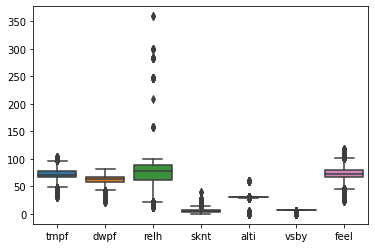

In [38]:
sns.boxplot(data=dft)

## Verifica-se os outlier dos voos cancelados de 2019 através do Box plot

<AxesSubplot:>

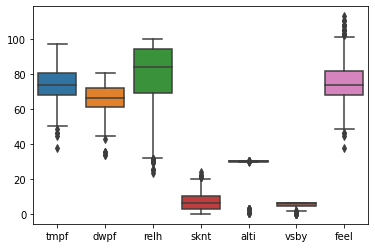

In [39]:
sns.boxplot(data=dfd)

## Verifica-se os outlier da variável 'alti' através do Box plot

<AxesSubplot:>

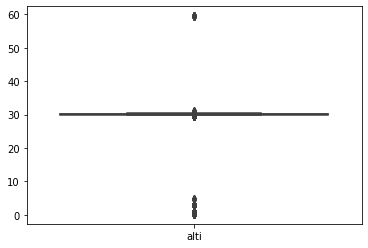

In [40]:
sns.boxplot(data=dft[["alti"]], orient="v")

<AxesSubplot:>

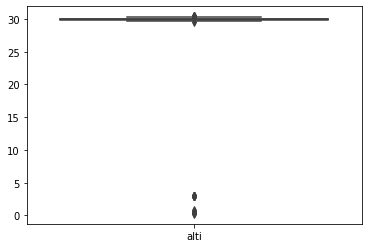

In [41]:
sns.boxplot(data=dfd[["alti"]], orient="v")

## Percebe-se que algumas colunas apresentam valores muito fora do padrão que possam ter ocorrido devido a vários fatores, como falha na instrumentação que capta os valores por exemplo.

### Cria-se uma nova coluna com o nome 'cancelado' que indica o valor 1 quando o voo for cancelado, e 0 quando for realizado.

In [42]:
can_met = ['XO']
dft['cancelado'] = dft['Código Justificativa'].str.contains('|'.join(can_met)).fillna(0).astype(float)

## Ocorre a remoção dos valores outliers

In [43]:
dfto = dft.drop(dft[dft.relh > 120].index)
dfto = dfto.drop(dfto[dfto.sknt > 32].index)
dfto = dfto.drop(dfto[dfto.alti < 20].index)
dfto = dfto.drop(dfto[dfto.alti > 50].index)
dfto

,Código Justificativa,tmpf,dwpf,relh,sknt,alti,vsby,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,feel,cancelado
0,NaN,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60,0.0
1,NaN,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60,0.0
2,WR,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60,0.0
3,RM,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60,0.0
4,TD,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585723,MX,69.8,66.2,88.34,0.0,30.12,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.80,0.0
585724,NaN,80.6,71.6,74.11,7.0,29.94,6.21,SCT,NaN,NaN,NaN,2500.00,NaN,NaN,NaN,NaN,84.57,0.0
585725,NaN,75.2,69.8,83.32,9.0,30.00,6.21,BKN,OVC,NaN,NaN,1700.00,3000.00,NaN,NaN,NaN,75.20,0.0
585726,MX,80.6,69.8,69.71,9.0,29.94,6.21,SCT,NaN,NaN,NaN,2300.00,NaN,NaN,NaN,NaN,83.90,0.0


## Diagrama de correlação para averiguar as colunas que apresentam aspectos em comum

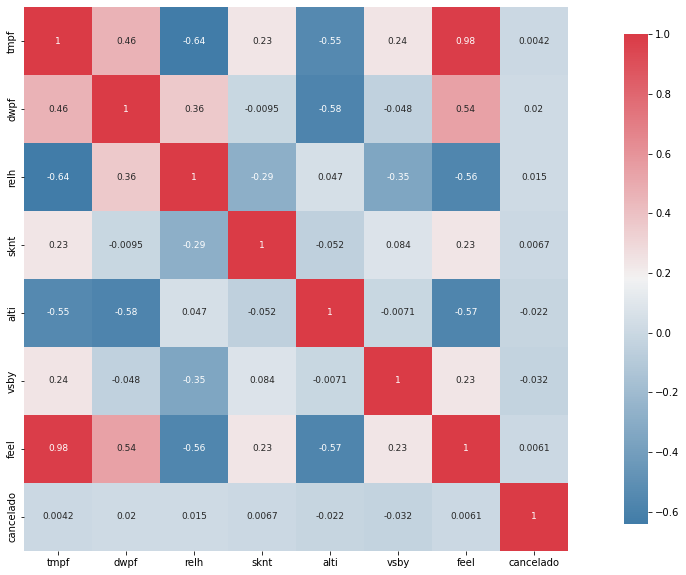

In [44]:
def plot_correlation_map( dfto ):
    corr = dfto.corr()
    _ , ax = plt.subplots( figsize =( 20 , 10 ) )
    cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
    _ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 9 })
plot_correlation_map(dfto)

## Cria-se um novo dataframe para os voos cancelados sem os outliers

In [45]:
dfdo = dfto[dfto['Código Justificativa'].isin(['XO'])]
dfdo

,Código Justificativa,tmpf,dwpf,relh,sknt,alti,vsby,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,feel,cancelado
679,XO,64.4,62.6,93.88,5.0,30.09,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.40,1.0
683,XO,64.4,62.6,93.88,5.0,30.09,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.40,1.0
1941,XO,64.4,62.6,93.88,16.0,30.03,6.21,NSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-RA,64.40,1.0
1948,XO,64.4,62.6,93.88,16.0,30.03,6.21,NSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-RA,64.40,1.0
2073,XO,68.0,68.0,100.00,0.0,30.06,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580166,XO,64.4,64.4,100.00,2.0,30.15,6.21,FEW,SCT,NaN,NaN,900.00,10000.00,NaN,NaN,NaN,64.40,1.0
581360,XO,78.8,69.8,73.95,5.0,30.18,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.39,1.0
581667,XO,86.0,59.0,40.14,5.0,29.97,6.21,SCT,NaN,NaN,NaN,4000.00,NaN,NaN,NaN,NaN,85.47,1.0
581672,XO,86.0,59.0,40.14,5.0,29.97,6.21,SCT,NaN,NaN,NaN,4000.00,NaN,NaN,NaN,NaN,85.47,1.0


## Apresenta o Box-plot de todos os voos nacionais

<AxesSubplot:>

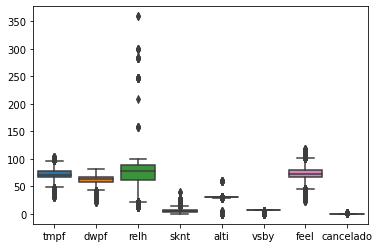

In [46]:
sns.boxplot(data=dft)

## Apresenta o Box-plot de todos os voos nacionais sem os outliers

<AxesSubplot:>

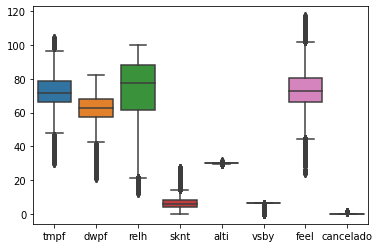

In [47]:
sns.boxplot(data=dfto)

## Apresenta o Box-plot de todos os voos cancelados sem os outliers

<AxesSubplot:>

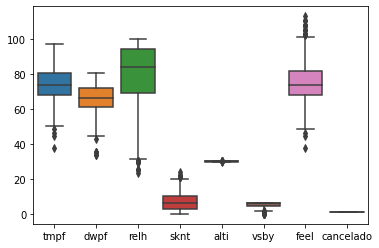

In [48]:
sns.boxplot(data=dfdo)

## Alguns Box Plots dos valores númericos para insights

Text(0.5, 1.0, 'Windspeed by Delay')

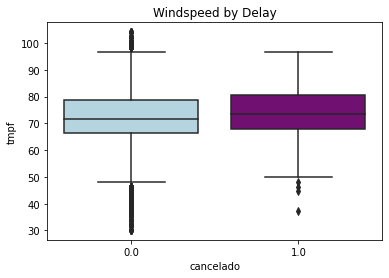

In [49]:
avg_wind = dfto[['cancelado', 'tmpf']]

sns.boxplot(x = "cancelado", 
            y="tmpf",
            palette=["lightblue", "purple"],
            data=avg_wind).set_title("Windspeed by Delay")

Text(0.5, 1.0, 'Windspeed by Delay')

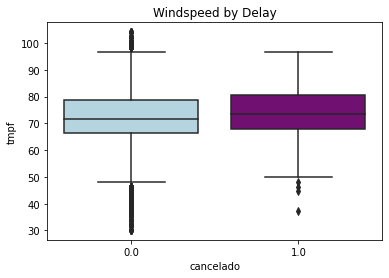

In [50]:
avg_wind = dfto[['cancelado', 'tmpf']]

sns.boxplot(x = "cancelado", 
            y="tmpf",
            palette=["lightblue", "purple"],
            data=avg_wind).set_title("Windspeed by Delay")

Text(0.5, 1.0, 'Windspeed by Delay')

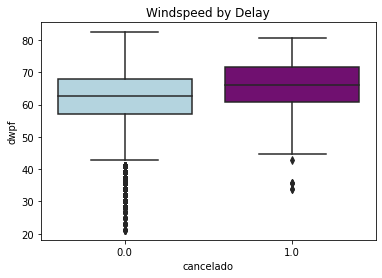

In [51]:
avg_wind = dfto[['cancelado', 'dwpf']]

sns.boxplot(x = "cancelado", 
            y="dwpf",
            palette=["lightblue", "purple"],
            data=avg_wind).set_title("Windspeed by Delay")

Text(0.5, 1.0, 'Windspeed by Delay')

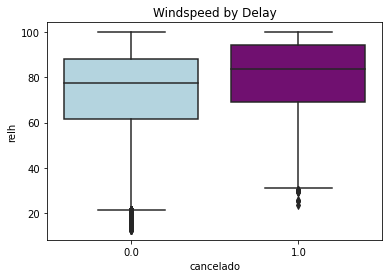

In [52]:
avg_wind = dfto[['cancelado', 'relh']]

sns.boxplot(x = "cancelado", 
            y="relh",
            palette=["lightblue", "purple"],
            data=avg_wind).set_title("Windspeed by Delay")

Text(0.5, 1.0, 'Windspeed by Delay')

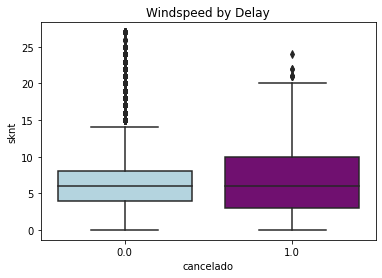

In [53]:
avg_wind = dfto[['cancelado', 'sknt']]

sns.boxplot(x = "cancelado", 
            y="sknt",
            palette=["lightblue", "purple"],
            data=avg_wind).set_title("Windspeed by Delay")

Text(0.5, 1.0, 'Windspeed by Delay')

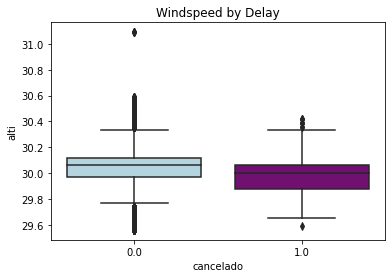

In [54]:
avg_wind = dfto[['cancelado', 'alti']]

sns.boxplot(x = "cancelado", 
            y="alti",
            palette=["lightblue", "purple"],
            data=avg_wind).set_title("Windspeed by Delay")

Text(0.5, 1.0, 'Windspeed by Delay')

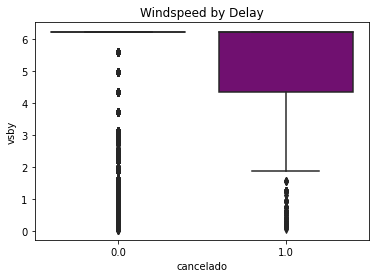

In [55]:
avg_wind = dfto[['cancelado', 'vsby']]

sns.boxplot(x = "cancelado", 
            y="vsby",
            palette=["lightblue", "purple"],
            data=avg_wind).set_title("Windspeed by Delay")

Text(0.5, 1.0, 'Windspeed by Delay')

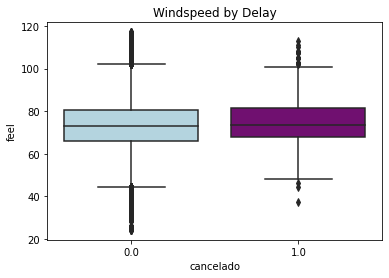

In [56]:
avg_wind = dfto[['cancelado', 'feel']]

sns.boxplot(x = "cancelado", 
            y="feel",
            palette=["lightblue", "purple"],
            data=avg_wind).set_title("Windspeed by Delay")

## Comandos para criação de mais alguns gráficos para insights

In [57]:
dfto_g = dfto[['tmpf','dwpf','relh','sknt','alti','vsby','feel','skyc1','skyc2','skyc3','skyc4','cancelado']]
dfto_g

,tmpf,dwpf,relh,sknt,alti,vsby,feel,skyc1,skyc2,skyc3,skyc4,cancelado
0,71.6,66.2,83.09,15.0,30.00,3.11,71.60,FEW,FEW,NaN,NaN,0.0
1,71.6,66.2,83.09,15.0,30.00,3.11,71.60,FEW,FEW,NaN,NaN,0.0
2,71.6,66.2,83.09,15.0,30.00,3.11,71.60,FEW,FEW,NaN,NaN,0.0
3,71.6,66.2,83.09,15.0,30.00,3.11,71.60,FEW,FEW,NaN,NaN,0.0
4,71.6,66.2,83.09,15.0,30.00,3.11,71.60,FEW,FEW,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
585723,69.8,66.2,88.34,0.0,30.12,6.21,69.80,NaN,NaN,NaN,NaN,0.0
585724,80.6,71.6,74.11,7.0,29.94,6.21,84.57,SCT,NaN,NaN,NaN,0.0
585725,75.2,69.8,83.32,9.0,30.00,6.21,75.20,BKN,OVC,NaN,NaN,0.0
585726,80.6,69.8,69.71,9.0,29.94,6.21,83.90,SCT,NaN,NaN,NaN,0.0


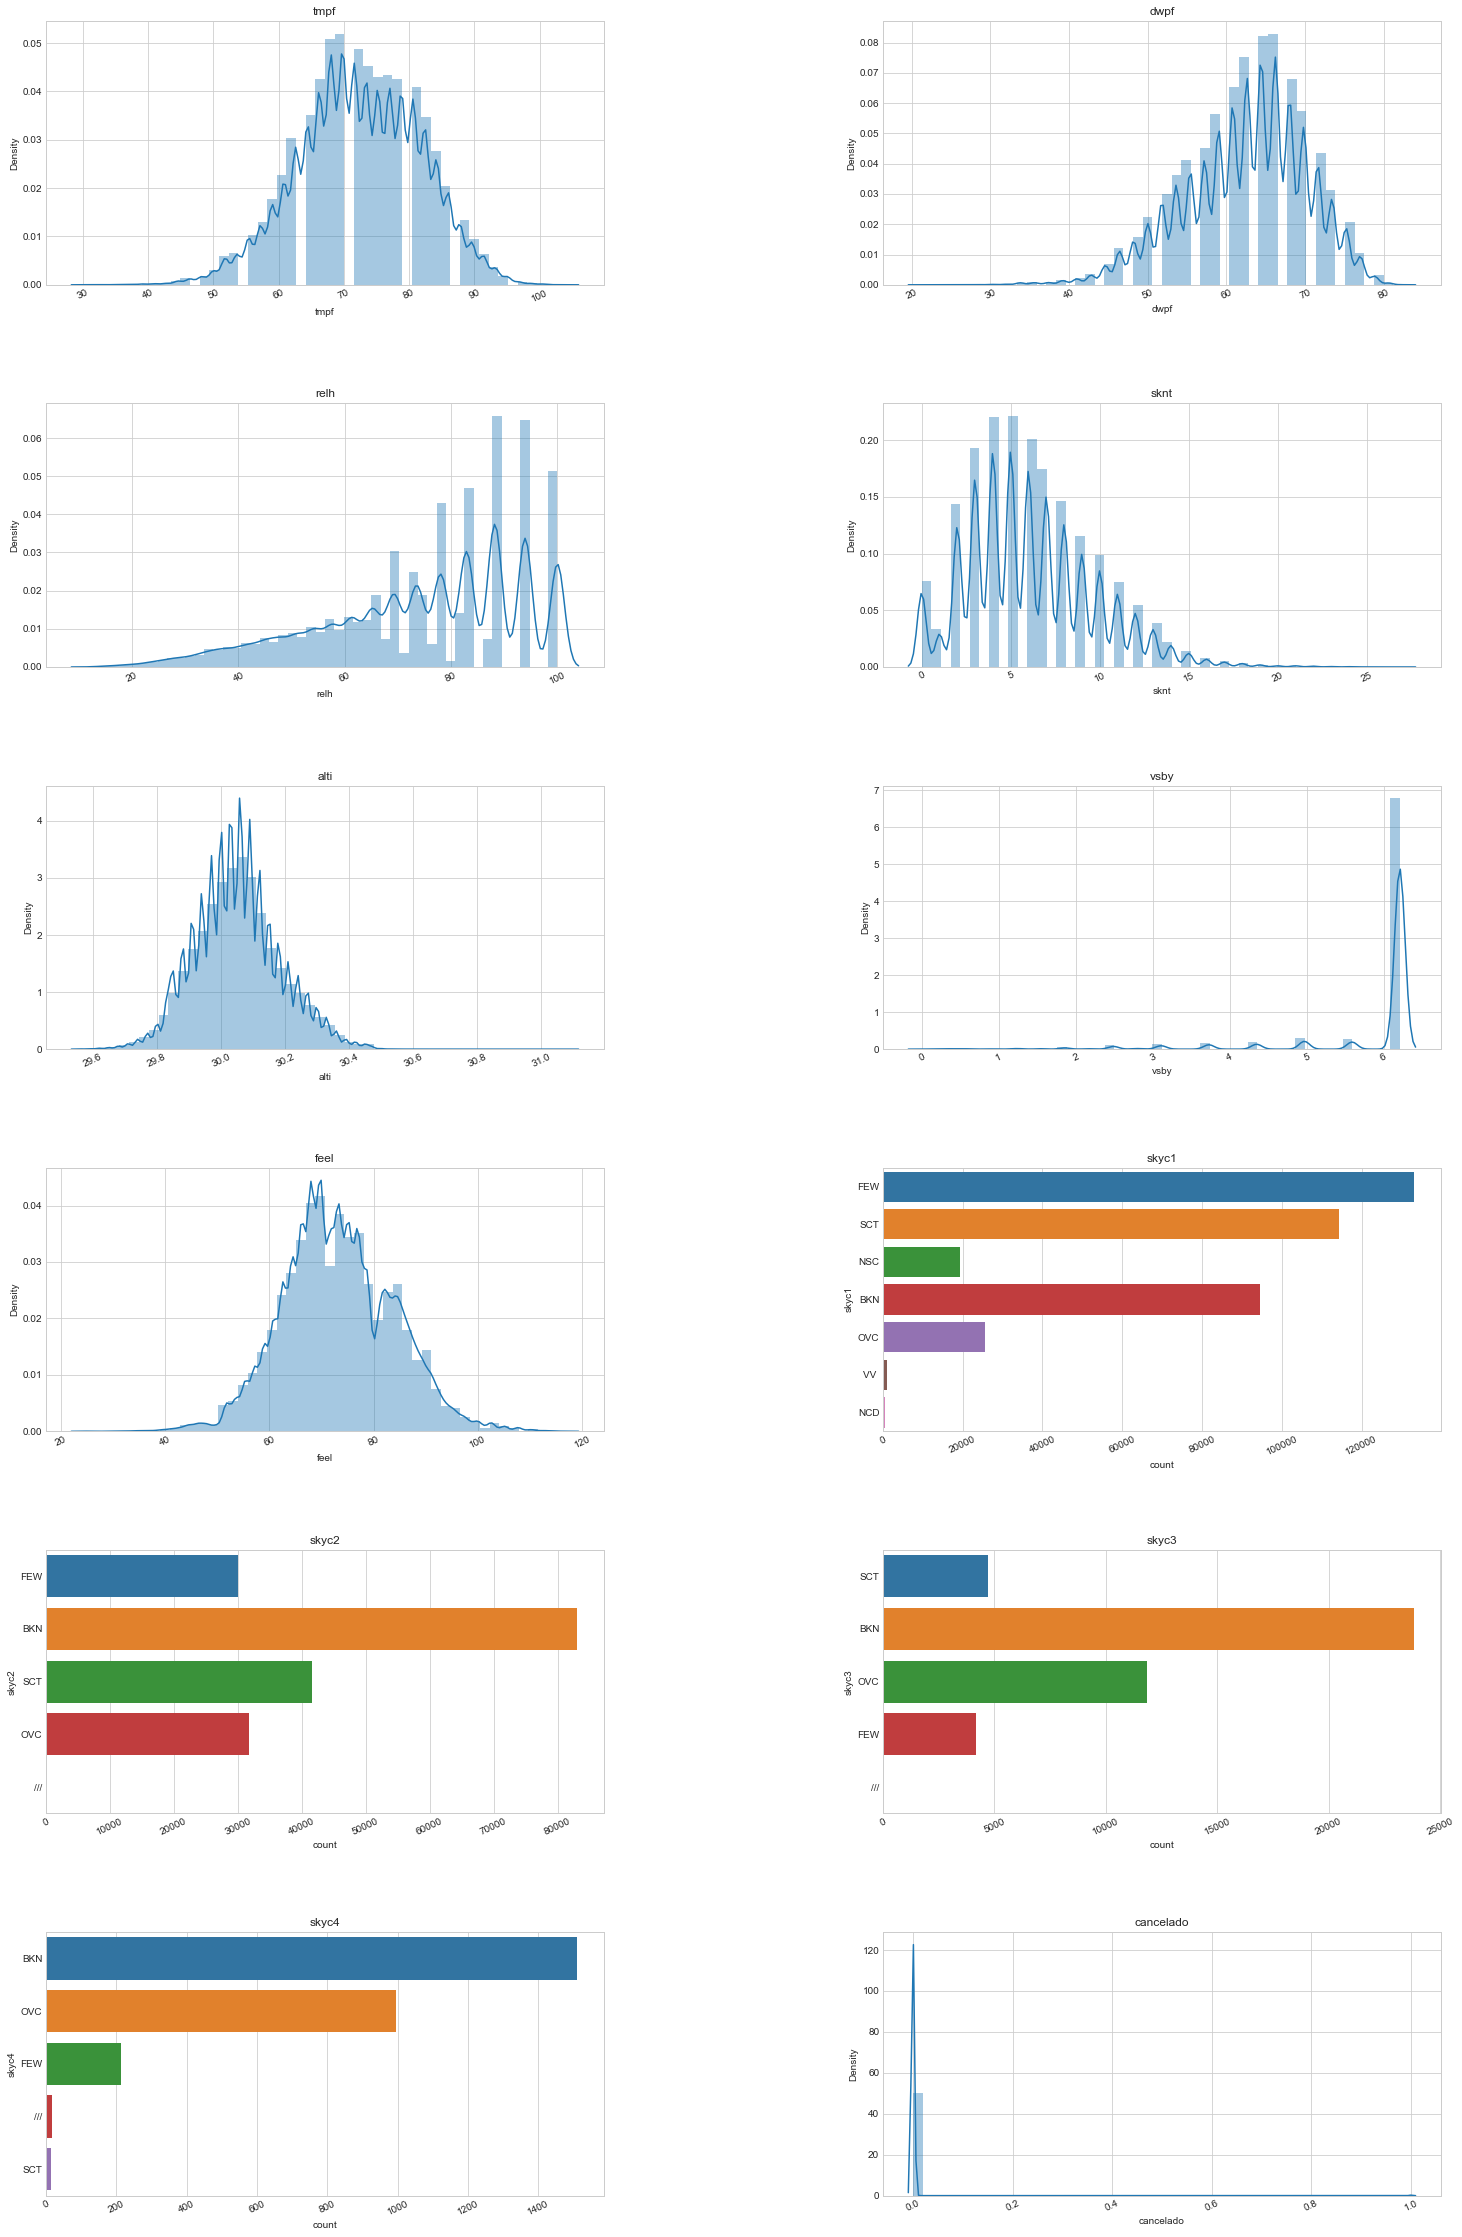

In [58]:
# Let’s plot the distribution of each feature
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(dfto_g, cols=2, width=25, height=40, hspace=0.45, wspace=0.5)

------------------------------------------------------------

# 4. Análise/exploração dos dados

### Verifica-se os voos totais que foram cancelados ou realizados.

,Cancelados_Realizados,N_VOOS
0,REALIZADO,965183
1,CANCELADO,17793


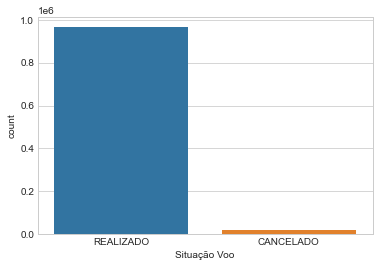

In [59]:
sns.countplot(x = dfx['Situação Voo'])
dfcr = dfx['Situação Voo'].value_counts().rename_axis('Cancelados_Realizados').reset_index(name='N_VOOS')
dfcr

<AxesSubplot:ylabel='Situação Voo'>

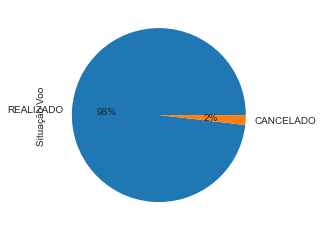

In [60]:
dfx['Situação Voo'].value_counts().plot(kind='pie', autopct='%1.0f%%')

## Análise das empresas aéreas por voos totais

In [61]:
dfx['ICAO Empresa Aérea'].value_counts()

AZU    302316
GLO    265582
TAM    250403
ONE     27589
PTB     13363
        ...  
SLM       214
EDW       199
CFG       164
FBZ        97
AZN        32
Name: ICAO Empresa Aérea, Length: 63, dtype: int64

<AxesSubplot:ylabel='ICAO Empresa Aérea'>

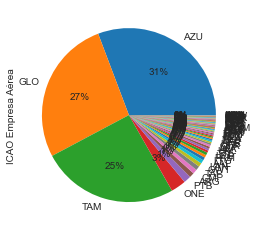

In [62]:
dfx['ICAO Empresa Aérea'].value_counts().plot(kind='pie', autopct='%1.0f%%')

,ICAO Empresa Aérea,N_VOOS_TOTAIS
0,AZU,302316
1,GLO,265582
2,TAM,250403
3,ONE,27589
4,PTB,13363
5,ARG,8885
6,CMP,8087
7,TAP,7750
8,OWT,7007
9,LAN,6509


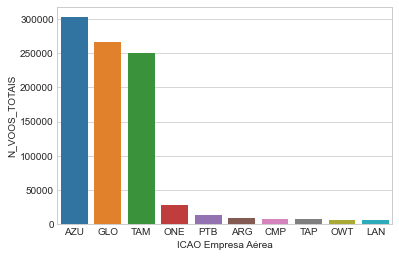

In [63]:
df2 = dfx['ICAO Empresa Aérea'].value_counts().iloc[:10].rename_axis('ICAO Empresa Aérea').reset_index(name='N_VOOS_TOTAIS')
sns.barplot(data=df2, x="ICAO Empresa Aérea", y="N_VOOS_TOTAIS")
df2

## Análise das empresas aéreas por voos cancelados por condições meteorológicas.

In [64]:
df3 = dfx_cancelados_met['ICAO Empresa Aérea'].value_counts().iloc[:10].rename_axis('COMPANHIAS').reset_index(name='N_VOOS_TOTAIS')

<AxesSubplot:ylabel='ICAO Empresa Aérea'>

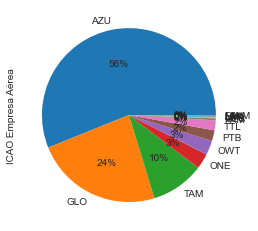

In [65]:
dfx_cancelados_met['ICAO Empresa Aérea'].value_counts().plot(kind='pie', autopct='%1.0f%%')

,COMPANHIAS,N_VOOS_TOTAIS
0,AZU,1215
1,GLO,512
2,TAM,215
3,ONE,62
4,OWT,58
5,PTB,43
6,TTL,40
7,PAM,8
8,GEC,3
9,UPS,3


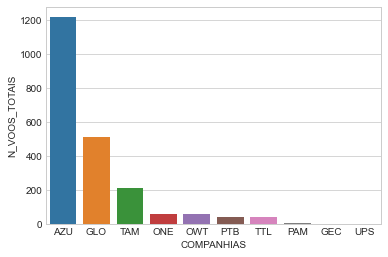

In [66]:
sns.barplot(data=df3, x="COMPANHIAS", y="N_VOOS_TOTAIS")
df3

### Análise dos voos cancelados e os motivos sendo 'XO' por condições meteorológicas

In [67]:
df1234 = dfx[dfx['Situação Voo'].isin(['CANCELADO'])]
df1234 = df1234['Código Justificativa'].value_counts().iloc[:50].rename_axis('Justificativa').reset_index(name='N_VOOS')
df1234.set_index('Justificativa', inplace=True)

,N_VOOS
Justificativa,
XN,9254
XT,3973
XO,2166
XL,717
XS,570
XB,484
XJ,308
XI,225
XM,57


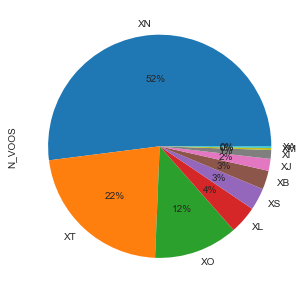

In [68]:
df1234.N_VOOS.plot(kind='pie', autopct='%1.0f%%', figsize=(5, 10))
df1234

## Como o banco de dados é muito extenso, decidiu-se por excluir algumas amostras, adotando a estratégia de selecionar apenas os 10 aeroportos com a maior quantidade de voos como espaço amostral.

,TOP_AEROS,N_VOOS
0,SBGR,138254
1,SBSP,88504
2,SBBR,61260
3,SBKP,58154
4,SBCF,50509
5,SBGL,47696
6,SBRJ,43131
7,SBRF,36068
8,SBPA,33939
9,SBCT,31347


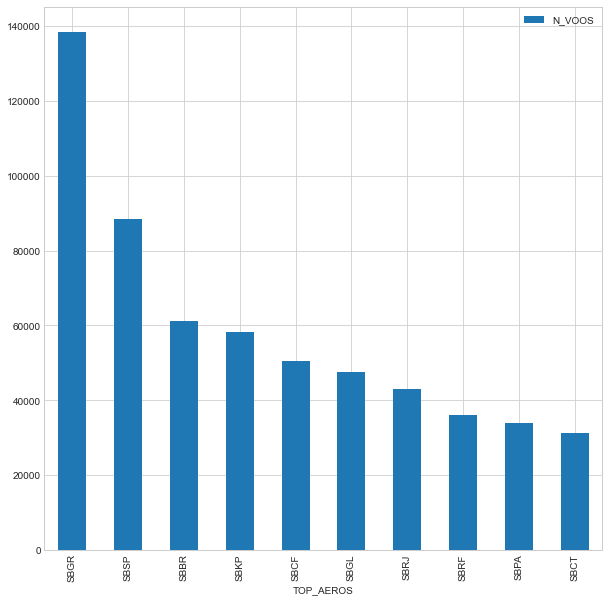

In [69]:
df1 = dfx['ICAO Aeródromo Origem'].value_counts().iloc[:10].rename_axis('TOP_AEROS').reset_index(name='N_VOOS')
plot = df1.plot.bar(y='N_VOOS',x='TOP_AEROS', figsize=(10, 10))
df1

## Verifica-se os 10 aeroportos com a maior quantidade de voos cancelados

,TOP_AEROS,N_VOOS
0,SBRJ,459
1,SBSP,263
2,SBGR,124
3,SBCT,94
4,SBKP,84
5,SBCX,84
6,SBCH,70
7,SBMG,58
8,SBNF,58
9,SBPA,45


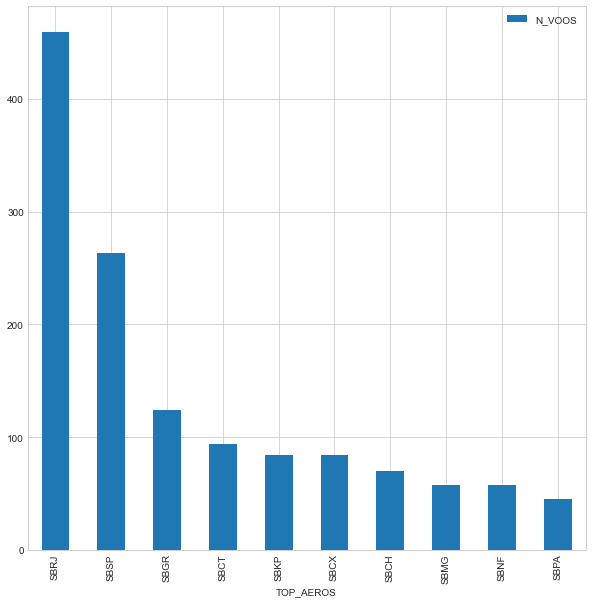

In [70]:
df123 = dfx_cancelados_met['ICAO Aeródromo Origem'].value_counts().iloc[:10].rename_axis('TOP_AEROS').reset_index(name='N_VOOS')
plot = df123.plot.bar(y='N_VOOS',x='TOP_AEROS', figsize=(10, 10))
df123

------------------------------------------------------------

# 5. Criação de modelo de ML (Machine Learning)

## Ocorre a separação entre y (coluna de voos cancelados) e X (variáveis meteorológicas que serão apreciadas).

In [71]:
y = dfto['cancelado']
X = dfto.drop(['cancelado', 'Código Justificativa'], axis = 1)
scaler = StandardScaler()

In [72]:
X

,tmpf,dwpf,relh,sknt,alti,vsby,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,feel
0,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
1,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
2,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
3,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
4,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585723,69.8,66.2,88.34,0.0,30.12,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.80
585724,80.6,71.6,74.11,7.0,29.94,6.21,SCT,NaN,NaN,NaN,2500.00,NaN,NaN,NaN,NaN,84.57
585725,75.2,69.8,83.32,9.0,30.00,6.21,BKN,OVC,NaN,NaN,1700.00,3000.00,NaN,NaN,NaN,75.20
585726,80.6,69.8,69.71,9.0,29.94,6.21,SCT,NaN,NaN,NaN,2300.00,NaN,NaN,NaN,NaN,83.90


## Transformação das variáveis categóricas em dummies e separação entre os dataframes de treino e de teste.

In [73]:
cat_cols_df = X.iloc[:, 7:]
cat_cols_list = ['skyc1', 'skyc2', 'skyc3','skyc4', 'skyl1','skyl2','skyl3','skyl4','wxcodes']
ohe = OneHotEncoder()
ohe.fit(cat_cols_df)
ohe_cat_cols = ohe.transform(cat_cols_df).toarray()
ohe_cat_cols_df = pd.DataFrame(ohe_cat_cols, columns = ohe.get_feature_names(cat_cols_df.columns))
num_cols_df = X[X.columns.difference(cat_cols_list)]
num_cols_df = pd.DataFrame(scaler.fit_transform(num_cols_df),index=num_cols_df.index, columns=num_cols_df.columns).reset_index(drop = True)
df_complete = num_cols_df.join(ohe_cat_cols_df)


X_train, X_test, y_train, y_test = train_test_split(df_complete, y, test_size = 0.25,  random_state = 42)

## No primeiro modelo testado abaixo, percebe-se que há uma alta porcentagem de acertos. Isso ocorre devido haver uma classe majoritária (classe dos voos REALIZADOS) e uma classe minoritária (classe dos voos CANCELADOS).

## Os modelos de machine learning sempre irão procurar o meio de ter o melhor aproveitamento de performance possível. Logo, é esperado que os modelos classifiquem quase todas as amostras de uma classe majoritária, pois assim, ela terá o melhor resultado possível. Esse resultado não expressa a realidade e deve ser descartado, e procurar um outro modelo de banco de dados, pois assim será feito um balanceamento para a solução dessa situação.



Training Recall Score, Random Forest:  0.1715686274509804
Test Recall Score, Random Forest:  0.08540925266903915
Training Precision Score, Random Forest:  0.7446808510638298
Test Precision Score, Random Forest:  0.5
Training Accuracy Score, Random Forest:  0.9983325656379548
Test Accuracy Score, Random Forest:  0.9980585073306893
Training F1 Score, Random Forest:  0.27888446215139445
Test F1 Score, Random Forest:  0.14589665653495443


Text(0.5, 1.0, 'Confusion Matrix for All Values From Random Forest')

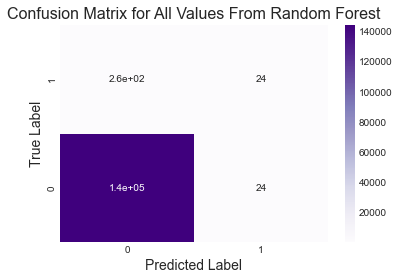

In [74]:
# Random forest for all values

forest = RandomForestClassifier()
forest.fit(X_train, y_train)
training_preds_rf = forest.predict(X_train)
test_preds_rf = forest.predict(X_test)


print('\n\nTraining Recall Score, Random Forest: ', recall_score(y_train, training_preds_rf))
print('Test Recall Score, Random Forest: ', recall_score(y_test, test_preds_rf))
print('Training Precision Score, Random Forest: ', precision_score(y_train, training_preds_rf))
print('Test Precision Score, Random Forest: ', precision_score(y_test, test_preds_rf))
print('Training Accuracy Score, Random Forest: ', accuracy_score(y_train, training_preds_rf))
print('Test Accuracy Score, Random Forest: ', accuracy_score(y_test, test_preds_rf))
print('Training F1 Score, Random Forest: ', f1_score(y_train, training_preds_rf))
print('Test F1 Score, Random Forest: ', f1_score(y_test, test_preds_rf))


# confusion matrix for random forest for all values

cnf_matrix_rf = confusion_matrix(y_test, test_preds_rf)

ax = sns.heatmap(cnf_matrix_rf, annot = True, cmap = 'Purples')
ax.set_ylim([0,2])
ax.set_xlabel('Predicted Label', fontsize = 14)
ax.set_ylabel('True Label', fontsize = 14)
ax.set_title('Confusion Matrix for All Values From Random Forest', fontsize = 16)

## PERCEBE-SE QUE O ALGORITMO IDENTIFICA MUITAS AMOSTRAS DA CLASSE COVID (CLASSE MAJORITÁRIA) E POUCA DA CLASSE INFLUENZA (CLASSE MINORITÁRIA)

------------------------------------------------------------

# 6. Interpretação dos resultados

## No gráfico abaixo percebemos muitas amostras da classe 'REALIZADOS' (0.0) e pouco da classe 'CANCELADOS' (1.0)

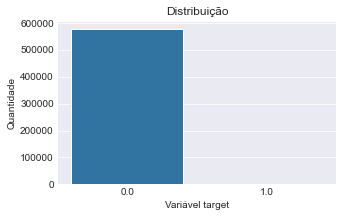

In [75]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize = (5, 3))
    ax = sns.countplot('cancelado', data=dfto);
    plt.title("Distribuição")
    plt.xlabel("Variável target")
    plt.ylabel("Quantidade")

In [76]:
dfto

,Código Justificativa,tmpf,dwpf,relh,sknt,alti,vsby,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,feel,cancelado
0,NaN,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60,0.0
1,NaN,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60,0.0
2,WR,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60,0.0
3,RM,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60,0.0
4,TD,71.6,66.2,83.09,15.0,30.00,3.11,FEW,FEW,NaN,NaN,4000.00,5000.00,NaN,NaN,-TSRA BR,71.60,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585723,MX,69.8,66.2,88.34,0.0,30.12,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.80,0.0
585724,NaN,80.6,71.6,74.11,7.0,29.94,6.21,SCT,NaN,NaN,NaN,2500.00,NaN,NaN,NaN,NaN,84.57,0.0
585725,NaN,75.2,69.8,83.32,9.0,30.00,6.21,BKN,OVC,NaN,NaN,1700.00,3000.00,NaN,NaN,NaN,75.20,0.0
585726,MX,80.6,69.8,69.71,9.0,29.94,6.21,SCT,NaN,NaN,NaN,2300.00,NaN,NaN,NaN,NaN,83.90,0.0


## Transforma em dummies todas as variáveis categóricas

In [77]:
dftoc = pd.get_dummies(data=dfto, columns=["skyc1", "skyc2", "skyc3","skyc4", "skyl1", "skyl2","skyl3", "skyl4", "wxcodes"])
dftoc

,Código Justificativa,tmpf,dwpf,relh,sknt,alti,vsby,feel,cancelado,skyc1_BKN,...,wxcodes_TS VCSH,wxcodes_TSGR,wxcodes_TSRA,wxcodes_TSRA BR,wxcodes_VCSH,wxcodes_VCSH BR,wxcodes_VCSH VCTS,wxcodes_VCTS,wxcodes_VCTS BR,wxcodes_VCTS PRFG BR
0,NaN,71.6,66.2,83.09,15.0,30.00,3.11,71.60,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,71.6,66.2,83.09,15.0,30.00,3.11,71.60,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,WR,71.6,66.2,83.09,15.0,30.00,3.11,71.60,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,RM,71.6,66.2,83.09,15.0,30.00,3.11,71.60,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,TD,71.6,66.2,83.09,15.0,30.00,3.11,71.60,0.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585723,MX,69.8,66.2,88.34,0.0,30.12,6.21,69.80,0.0,0,...,0,0,0,0,0,0,0,0,0,0
585724,NaN,80.6,71.6,74.11,7.0,29.94,6.21,84.57,0.0,0,...,0,0,0,0,0,0,0,0,0,0
585725,NaN,75.2,69.8,83.32,9.0,30.00,6.21,75.20,0.0,1,...,0,0,0,0,0,0,0,0,0,0
585726,MX,80.6,69.8,69.71,9.0,29.94,6.21,83.90,0.0,0,...,0,0,0,0,0,0,0,0,0,0


## Separação da variável target

In [78]:
y = dftoc["cancelado"]
X = dftoc.drop(columns=['cancelado','Código Justificativa'])

## 4.3 PARA CORREÇÃO DESSE FATO É NECESSÁRIO FAZER O BALANCEAMENTO DA CLASSES E PARA ISSO FOI UTILIZADO A FUNÇÃO NEARMISS PELA BIBLIOTECA IMBLEARN

## Para a correção dessa situação é necessário fazer o balanceamento das classes. Para isso foi utilizado a função NearMiss da biblioteca Imblearn

In [79]:
#from imblearn.under_sampling import NearMiss
nr = NearMiss(sampling_strategy='auto', version=1, n_neighbors=1, n_neighbors_ver3=1, n_jobs=8)
X, y = nr.fit_resample(X, y)

In [80]:
y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2189    1.0
2190    1.0
2191    1.0
2192    1.0
2193    1.0
Name: cancelado, Length: 2194, dtype: float64

## O balanceamento das classes se dá a partir da seleção aleatória de amostras da classe majoritária equivalendo a quantidade de amostras da classe minoritária, como é demonstrado no gráfico a seguir:

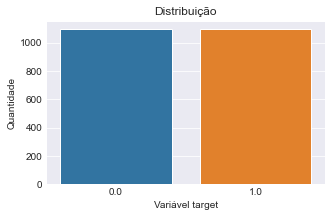

In [81]:
with sns.axes_style("darkgrid"):

#plt.style.use("ggplot")
    plt.figure(figsize = (5, 3))
    ax = sns.countplot(x=y)
    plt.title("Distribuição")
    plt.xlabel("Variável target")
    plt.ylabel("Quantidade")

------------------------------------------------------------

# 7. Comunicação dos resultados

## Repete-se o processo de transformação e separação

In [82]:
cat_cols_df = X.iloc[:, 7:]
ohe = OneHotEncoder()
ohe.fit(cat_cols_df)
ohe_cat_cols = ohe.transform(cat_cols_df).toarray()
ohe_cat_cols_df = pd.DataFrame(ohe_cat_cols, columns = ohe.get_feature_names(cat_cols_df.columns))
num_cols_df = X[X.columns.difference(cat_cols_list)]
num_cols_df = pd.DataFrame(scaler.fit_transform(num_cols_df),index=num_cols_df.index, columns=num_cols_df.columns).reset_index(drop = True)
df_complete = num_cols_df.join(ohe_cat_cols_df)


X_train, X_test, y_train, y_test = train_test_split(df_complete, y, test_size = 0.25,  random_state = 42)

## Roda-se os modelos de machine learning com o banco de dados final, limpo e balanceado.



Training Recall Score, Random Forest:  0.8983050847457628
Test Recall Score, Random Forest:  0.915129151291513
Training Precision Score, Random Forest:  0.9867021276595744
Test Precision Score, Random Forest:  0.9763779527559056
Training Accuracy Score, Random Forest:  0.9428571428571428
Test Accuracy Score, Random Forest:  0.9471766848816029
Training F1 Score, Random Forest:  0.9404309252217997
Test F1 Score, Random Forest:  0.9447619047619048


Text(0.5, 1.0, 'Confusion Matrix for All Values From Random Forest')

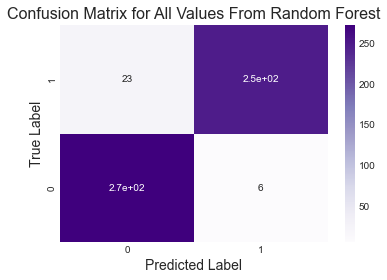

In [83]:
# Random forest for all values

forest = RandomForestClassifier()
forest.fit(X_train, y_train)
training_preds_rf = forest.predict(X_train)
test_preds_rf = forest.predict(X_test)

print('\n\nTraining Recall Score, Random Forest: ', recall_score(y_train, training_preds_rf))
print('Test Recall Score, Random Forest: ', recall_score(y_test, test_preds_rf))
print('Training Precision Score, Random Forest: ', precision_score(y_train, training_preds_rf))
print('Test Precision Score, Random Forest: ', precision_score(y_test, test_preds_rf))
print('Training Accuracy Score, Random Forest: ', accuracy_score(y_train, training_preds_rf))
print('Test Accuracy Score, Random Forest: ', accuracy_score(y_test, test_preds_rf))
print('Training F1 Score, Random Forest: ', f1_score(y_train, training_preds_rf))
print('Test F1 Score, Random Forest: ', f1_score(y_test, test_preds_rf))


# confusion matrix for random forest for all values

cnf_matrix_rf = confusion_matrix(y_test, test_preds_rf)

ax = sns.heatmap(cnf_matrix_rf, annot = True, cmap = 'Purples')
ax.set_ylim([0,2])
ax.set_xlabel('Predicted Label', fontsize = 14)
ax.set_ylabel('True Label', fontsize = 14)
ax.set_title('Confusion Matrix for All Values From Random Forest', fontsize = 16)



Training Recall Score, KNN:  0.8256658595641646
Test Recall Score, KNN:  0.7859778597785978
Training Precision Score, KNN:  0.9941690962099126
Test Precision Score, KNN:  0.9770642201834863
Training Accuracy Score, KNN:  0.9100303951367781
Test Accuracy Score, KNN:  0.8852459016393442
Training F1 Score, KNN:  0.9021164021164021
Test F1 Score, KNN:  0.8711656441717792


Text(0.5, 1.0, 'Confusion Matrix for All Values From KNN')

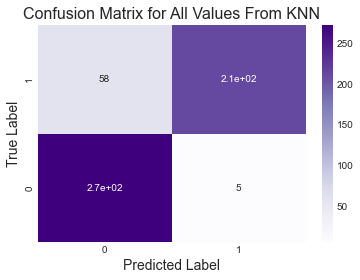

In [84]:
# KNN for all values

KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
training_preds_rf = KNN.predict(X_train)
test_preds_rf = KNN.predict(X_test)

print('\n\nTraining Recall Score, KNN: ', recall_score(y_train, training_preds_rf))
print('Test Recall Score, KNN: ', recall_score(y_test, test_preds_rf))
print('Training Precision Score, KNN: ', precision_score(y_train, training_preds_rf))
print('Test Precision Score, KNN: ', precision_score(y_test, test_preds_rf))
print('Training Accuracy Score, KNN: ', accuracy_score(y_train, training_preds_rf))
print('Test Accuracy Score, KNN: ', accuracy_score(y_test, test_preds_rf))
print('Training F1 Score, KNN: ', f1_score(y_train, training_preds_rf))
print('Test F1 Score, KNN: ', f1_score(y_test, test_preds_rf))


# confusion matrix for KNN for all values

cnf_matrix_rf = confusion_matrix(y_test, test_preds_rf)

ax = sns.heatmap(cnf_matrix_rf, annot = True, cmap = 'Purples')
ax.set_ylim([0,2])
ax.set_xlabel('Predicted Label', fontsize = 14)
ax.set_ylabel('True Label', fontsize = 14)
ax.set_title('Confusion Matrix for All Values From KNN', fontsize = 16)



Training Recall Score, Logistic Regression:  0.7191283292978208
Test Recall Score, Logistic Regression:  0.7158671586715867
Training Precision Score, Logistic Regression:  0.9369085173501577
Test Precision Score, Logistic Regression:  0.9371980676328503
Training Accuracy Score, Logistic Regression:  0.8346504559270517
Test Accuracy Score, Logistic Regression:  0.8360655737704918
Training F1 Score, Logistic Regression:  0.8136986301369863
Test F1 Score, Logistic Regression:  0.8117154811715481


Text(0.5, 1.0, 'Confusion Matrix for All Values From Logistic Regression')

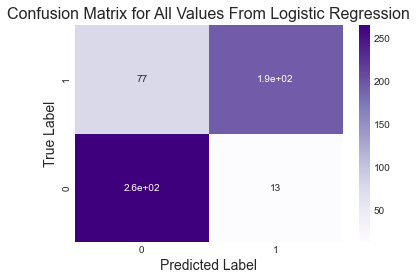

In [85]:
# Logistic Regression for all values

logistic = LogisticRegression()
logistic.fit(X_train, y_train)
training_preds_rf = logistic.predict(X_train)
test_preds_rf = logistic.predict(X_test)

print('\n\nTraining Recall Score, Logistic Regression: ', recall_score(y_train, training_preds_rf))
print('Test Recall Score, Logistic Regression: ', recall_score(y_test, test_preds_rf))
print('Training Precision Score, Logistic Regression: ', precision_score(y_train, training_preds_rf))
print('Test Precision Score, Logistic Regression: ', precision_score(y_test, test_preds_rf))
print('Training Accuracy Score, Logistic Regression: ', accuracy_score(y_train, training_preds_rf))
print('Test Accuracy Score, Logistic Regression: ', accuracy_score(y_test, test_preds_rf))
print('Training F1 Score, Logistic Regression: ', f1_score(y_train, training_preds_rf))
print('Test F1 Score, Logistic Regression: ', f1_score(y_test, test_preds_rf))


# confusion matrix for Logistic Regression for all values

cnf_matrix_rf = confusion_matrix(y_test, test_preds_rf)

ax = sns.heatmap(cnf_matrix_rf, annot = True, cmap = 'Purples')
ax.set_ylim([0,2])
ax.set_xlabel('Predicted Label', fontsize = 14)
ax.set_ylabel('True Label', fontsize = 14)
ax.set_title('Confusion Matrix for All Values From Logistic Regression', fontsize = 16)

## K-Fold Cross Validation

In [86]:
X_df = np.concatenate((X_train, X_test), axis = 0)
X_df.shape

(2194, 830)

In [87]:
Y_df = np.concatenate((y_train, y_test), axis = 0)
Y_df.shape

(2194,)

In [88]:
resultados_random_forest = []
resultados_knn = []
resultados_logistic = []

for i in range(30):
    print(i)
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    
    
    random_forest = RandomForestClassifier()
    scores = cross_val_score(random_forest, X_df, Y_df, cv = kfold)
    resultados_random_forest.append(scores.mean())
    
    knn = KNeighborsClassifier()
    scores = cross_val_score(knn, X_df, Y_df, cv = kfold)
    resultados_knn.append(scores.mean())
    
    logistic = LogisticRegression()
    scores = cross_val_score(logistic, X_df, Y_df, cv = kfold)
    resultados_logistic.append(scores.mean())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [89]:
resultados = pd.DataFrame({'Random forest': resultados_random_forest,
                           'KNN': resultados_knn, 'Logistic': resultados_logistic})
resultados

,Random forest,KNN,Logistic
0,0.937121,0.895185,0.826812
1,0.937549,0.895602,0.826804
2,0.936644,0.890606,0.822231
3,0.938001,0.898352,0.824508
4,0.936200,0.896092,0.822254
5,0.938904,0.899234,0.821768
6,0.935745,0.893354,0.824095
7,0.937547,0.896069,0.826791
8,0.935749,0.894718,0.822688
9,0.936669,0.889265,0.824985


## No gráfico abaixo avalia-se que o algoritmo Random forest foi o que apresentou melhor aproveitamento

[Text(0, 0, 'Random forest'), Text(1, 0, 'KNN'), Text(2, 0, 'Logistic')]

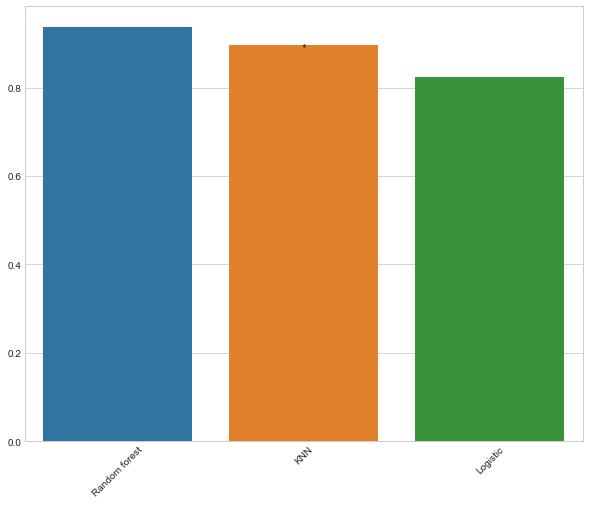

In [90]:
# Plotando o Gráfico dos Resultados
plt.figure(figsize=(10,8))
plot_resultado = sns.barplot(data=resultados)
plot_resultado.set_xticklabels(plot_resultado.get_xticklabels(),rotation=45)

## Média de performance de cada algoritmo de machine learning apresentado

In [91]:
resultados.mean()

Random forest    0.936482
KNN              0.895535
Logistic         0.823765
dtype: float64

------------------------------------------------------------

# É possível avaliar esse algoritmo de forma positiva, podendo apresentar um 'diagnóstico artificial' com cerca de 90% de precisão, se determinado voo será cancelado ou não dada as condições meteorológicas presentes no momento do cancelamento.